In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re

In [20]:
path = "data/실물지표/신용카드사용액raw.csv"
df_wide = pd.read_csv(path)

# 1) 메타 컬럼 / 월별 컬럼 분리
meta_cols = ['통계표', '계정항목', '금융기관 유형코드', '단위', '변환']
date_cols = [c for c in df_wide.columns if c not in meta_cols]

# 2) wide -> long
df = df_wide.melt(
    id_vars=meta_cols,
    value_vars=date_cols,
    var_name='date',
    value_name='value'
)

# 3) 날짜 파싱: 'Jan-03' 형태 -> datetime (월초로 들어감)
df['date'] = pd.to_datetime(df['date'], format='%b-%y')
df = df.sort_values(['통계표','계정항목','금융기관 유형코드','단위','변환','date'])

# 4) 숫자 변환 (콤마 제거)
df['value'] = (
    df['value'].astype(str)
              .str.replace(',', '', regex=False)
              .replace('', np.nan)
              .astype(float)
)

# 5) 12개월 누적 로그변화율 (YoY log diff)
grp_cols = ['통계표','계정항목','금융기관 유형코드','단위','변환']
df['log_yoy'] = df.groupby(grp_cols)['value'].transform(lambda s: np.log(s).diff(12))

# 6) z-score (시계열 기준)
df['credit_log_yoy_z'] = df.groupby(grp_cols)['log_yoy'].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

# 7) 결과: 필요 컬럼만
out = df[['date'] + grp_cols + ['value', 'log_yoy', 'credit_log_yoy_z']].dropna(subset=['log_yoy'])

out = out[['date','credit_log_yoy_z']]
out.to_csv('data/실물지표/신용카드사용액.csv')

In [13]:
import pandas as pd
import numpy as np
import re

path = "data/실물지표/전산업생산지수raw.csv"

# 1) EUC-KR로 읽기
df_wide = pd.read_csv(path, encoding="euc-kr")

# 2) wide -> long
meta_col = "산업별 지수"
date_cols = [c for c in df_wide.columns if c != meta_col]

df = df_wide.melt(
    id_vars=[meta_col],
    value_vars=date_cols,
    var_name="date_raw",
    value_name="ipi"
)

# 3) 날짜 정리: "2025.11 p)" -> "2025.11"
df["date_raw"] = df["date_raw"].astype(str)
df["date_clean"] = df["date_raw"].str.replace(r"\s*p\)\s*$", "", regex=True).str.strip()

# "YYYY.MM" -> datetime (월초)
df["date"] = pd.to_datetime(df["date_clean"], format="%Y.%m")

# 4) 숫자형 변환
df["ipi"] = pd.to_numeric(df["ipi"], errors="coerce")

# 정렬
df = df.sort_values("date").reset_index(drop=True)

# 5) 12개월 로그변화율 (YoY log diff)
df["ipi_log_yoy"] = np.log(df["ipi"]).diff(12)

# 6) z-score (전체 기간 기준)
mu = df["ipi_log_yoy"].mean(skipna=True)
sd = df["ipi_log_yoy"].std(skipna=True, ddof=0)  # ddof=0 권장(표준화 일관성)
df["ipi_log_yoy_z"] = (df["ipi_log_yoy"] - mu) / sd

# 7) 결과
out = df[[meta_col, "date", "ipi", "ipi_log_yoy", "ipi_log_yoy_z"]].dropna(subset=["ipi_log_yoy"]).reset_index(drop=True)
out.head(10)

out = out[['date','ipi_log_yoy_z']]
out.to_csv('data/실물지표/전산업생산지수.csv')

In [16]:
path = "data/실물지표/소매판매액지수raw.csv"

# 1) 인코딩(cp949)로 읽기
df_wide = pd.read_csv(path, encoding="cp949")

# 2) 파일에 섞여있는 '설명용 1행(업종별/불변지수...)' 제거
#    (현재 파일은 업종별 컬럼 값이 '업종별'인 행이 1개 들어있음)
df_wide = df_wide[df_wide["업종별"] != "업종별"].copy()

# 3) wide -> long
meta_col = "업종별"
date_cols = [c for c in df_wide.columns if c != meta_col]

df = df_wide.melt(
    id_vars=[meta_col],
    value_vars=date_cols,
    var_name="date_raw",
    value_name="retail"
)

# 4) 날짜 정리: "2025.11 p)" -> "2025.11"
df["date_raw"] = df["date_raw"].astype(str)
df["date_clean"] = df["date_raw"].str.replace(r"\s*p\)\s*$", "", regex=True).str.strip()
df["date"] = pd.to_datetime(df["date_clean"], format="%Y.%m")

# 5) 숫자 변환
df["retail"] = (
    df["retail"].astype(str)
                .str.replace(",", "", regex=False)
)
df["retail"] = pd.to_numeric(df["retail"], errors="coerce")

# 6) 정렬
df = df.sort_values([meta_col, "date"]).reset_index(drop=True)

# 7) 12개월 로그변화율 (YoY log diff)
df["retail_log_yoy"] = df.groupby(meta_col)["retail"].transform(lambda s: np.log(s).diff(12))

# 8) z-score (시계열 기준)
df["retail_log_yoy_z"] = df.groupby(meta_col)["retail_log_yoy"].transform(
    lambda s: (s - s.mean()) / s.std(ddof=0)
)

# 9) 결과
out = df[[meta_col, "date", "retail", "retail_log_yoy", "retail_log_yoy_z"]].dropna(subset=["retail_log_yoy"]).reset_index(drop=True)
out.head(10)
out = out[['date','retail_log_yoy_z']]
out.to_csv('data/실물지표/소매판매액지수.csv')

In [32]:
retail_path = "data/실물지표/소매판매액지수.csv"
card_path = "data/실물지표/신용카드사용액.csv"
prod_path = "data/실물지표/전산업생산지수.csv"

# 로드
retail = pd.read_csv(retail_path)
card = pd.read_csv(card_path)
prod = pd.read_csv(prod_path)

In [33]:
# 날짜 컬럼 datetime 변환
retail['date'] = pd.to_datetime(retail['date'])
card['date'] = pd.to_datetime(card['date'])
prod['date'] = pd.to_datetime(prod['date'])

# 필요한 컬럼만 선택 (예시: yoy_z_full 사용)
retail = retail[['date', 'retail_log_yoy_z']].rename(columns={'retail_log_yoy_z': 'retail'})
card = card[['date', 'credit_log_yoy_z']].rename(columns={'credit_log_yoy_z': 'card'})
prod = prod[['date', 'ipi_log_yoy_z']].rename(columns={'ipi_log_yoy_z': 'production'})


In [36]:
start_date = "2011-01-01"

retail = retail[retail['date'] >= start_date]
card = card[card['date'] >= start_date]
prod = prod[prod['date'] >= start_date]

In [37]:
df_real = retail.merge(card, on='date', how='inner').merge(prod, on='date', how='inner')

df_real = df_real.sort_values('date')


In [38]:
df_real['real_index'] = df_real[['retail', 'card', 'production']].mean(axis=1)
df_real.to_csv('data/실물지표/실물지표계산.csv')

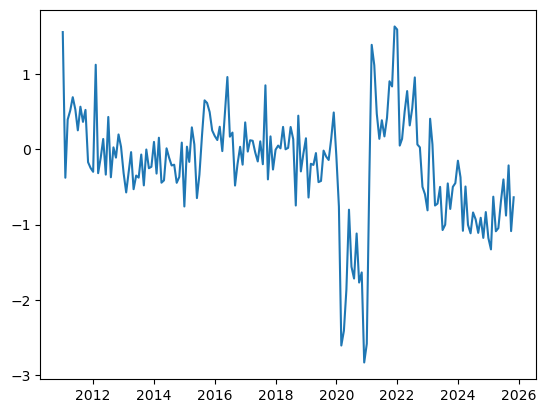

In [39]:
plt.plot(df_real['date'],df_real['real_index'])

# 금융지표

## 코스피

In [50]:
path = "data/금융지표/kospiraw.csv"

# 1️⃣ 데이터 읽기 (Investing.com 형식 가정)
df = pd.read_csv(path)

# 컬럼 확인
print(df.columns)

# 2️⃣ 날짜 처리
# 보통 '날짜' 또는 'Date'
if '날짜' in df.columns:
    df['date'] = pd.to_datetime(df['날짜'])
elif 'Date' in df.columns:
    df['date'] = pd.to_datetime(df['Date'])
else:
    raise ValueError("날짜 컬럼 이름 확인 필요")

df = df.sort_values('date').reset_index(drop=True)

# 3️⃣ 종가 컬럼 정리
# 보통 '종가' 또는 'Price'
if '종가' in df.columns:
    price_col = '종가'
elif 'Price' in df.columns:
    price_col = 'Price'
else:
    raise ValueError("가격 컬럼 이름 확인 필요")

df['price'] = (
    df[price_col]
      .astype(str)
      .str.replace(',', '', regex=False)
      .astype(float)
)

# 4️⃣ 월별 데이터인지 확인
# 일별이면 월말 기준으로 리샘플링
if df['date'].diff().dt.days.median() < 25:
    df = df.set_index('date').resample('M').last().reset_index()

# 5️⃣ 12개월 로그변화율
df['kospi_log_yoy'] = np.log(df['price']).diff(12)

# 6️⃣ z-score 계산
mu = df['kospi_log_yoy'].mean(skipna=True)
sd = df['kospi_log_yoy'].std(skipna=True, ddof=0)

df['kospi_log_yoy_z'] = (df['kospi_log_yoy'] - mu) / sd

# 7️⃣ 결과
result = df[['date', 'price', 'kospi_log_yoy', 'kospi_log_yoy_z']].dropna().reset_index(drop=True)
result.head(10)
result.to_csv('data/금융지표/kospi.csv')
result

Index(['날짜', '종가', '시가', '고가', '저가', '거래량', '변동 %'], dtype='object')


,date,price,kospi_log_yoy,kospi_log_yoy_z
0,1982-05-01,114.57,-0.097474,-0.603736
1,1982-06-01,123.64,-0.198580,-0.957944
2,1982-07-01,125.08,-0.168934,-0.854084
3,1982-08-01,121.94,-0.138827,-0.748610
4,1982-09-01,119.71,-0.100000,-0.612585
...,...,...,...,...
521,2025-10-01,4107.50,0.474312,1.399415
522,2025-11-01,3926.59,0.469274,1.381764
523,2025-12-01,4214.17,0.563196,1.710804
524,2026-01-01,5224.36,0.730118,2.295582


## 환율

In [49]:
path = "data/금융지표/환율raw.csv"

# 1️⃣ 데이터 읽기 (Investing.com 형식 가정)
df = pd.read_csv(path)

# 컬럼 확인
print(df.columns)

# 2️⃣ 날짜 처리
# 보통 '날짜' 또는 'Date'
if '날짜' in df.columns:
    df['date'] = pd.to_datetime(df['날짜'])
elif 'Date' in df.columns:
    df['date'] = pd.to_datetime(df['Date'])
else:
    raise ValueError("날짜 컬럼 이름 확인 필요")

df = df.sort_values('date').reset_index(drop=True)

# 3️⃣ 종가 컬럼 정리
# 보통 '종가' 또는 'Price'
if '종가' in df.columns:
    price_col = '종가'
elif 'Price' in df.columns:
    price_col = 'Price'
else:
    raise ValueError("가격 컬럼 이름 확인 필요")

df['price'] = (
    df[price_col]
      .astype(str)
      .str.replace(',', '', regex=False)
      .astype(float)
)

# 4️⃣ 월별 데이터인지 확인
# 일별이면 월말 기준으로 리샘플링
if df['date'].diff().dt.days.median() < 25:
    df = df.set_index('date').resample('M').last().reset_index()

# 5️⃣ 12개월 로그변화율
df['exchange_log_yoy'] = np.log(df['price']).diff(12)

# 6️⃣ z-score 계산
mu = df['exchange_log_yoy'].mean(skipna=True)
sd = df['exchange_log_yoy'].std(skipna=True, ddof=0)

df['exchange_log_yoy_z'] = (df['exchange_log_yoy'] - mu) / sd

# 7️⃣ 결과
result = df[['date', 'price', 'exchange_log_yoy', 'exchange_log_yoy_z']].dropna().reset_index(drop=True)
result.head(10)
result.to_csv('data/금융지표/환율.csv')
result

Index(['날짜', '종가', '시가', '고가', '저가', '거래량', '변동 %'], dtype='object')


,date,price,exchange_log_yoy,exchange_log_yoy_z
0,1982-05-01,731.75,0.066896,0.449934
1,1982-06-01,741.30,0.081618,0.580743
2,1982-07-01,743.80,0.079511,0.562020
3,1982-08-01,744.90,0.079679,0.563518
4,1982-09-01,743.05,0.086834,0.627093
...,...,...,...,...
521,2025-10-01,1429.22,0.040437,0.214821
522,2025-11-01,1467.62,0.050984,0.308543
523,2025-12-01,1440.62,-0.024790,-0.364768
524,2026-01-01,1450.80,-0.004463,-0.184148


## 금리

In [53]:
import pandas as pd
import numpy as np

path = "data/금융지표/시장금리raw.csv"

# 1) 파일 읽기 (이 파일은 utf-8로 잘 읽힘)
df_wide = pd.read_csv(path, encoding="utf-8")

# 2) wide -> long (Jan-04, Feb-04 ... 를 세로로)
meta_cols = ["통계표", "계정항목", "단위", "변환"]
date_cols = [c for c in df_wide.columns if c not in meta_cols]

df_long = df_wide.melt(
    id_vars=meta_cols,
    value_vars=date_cols,
    var_name="date",
    value_name="rate"
)

# 3) 날짜 파싱: 'Jan-04' -> datetime (월초 기준)
df_long["date"] = pd.to_datetime(df_long["date"], format="%b-%y")

# 4) 숫자 변환
df_long["rate"] = pd.to_numeric(df_long["rate"], errors="coerce")

# 5) 국고채/회사채를 컬럼으로 피벗
pivot = df_long.pivot_table(
    index="date",
    columns="계정항목",
    values="rate",
    aggfunc="first"
).sort_index()

# 6) 스프레드(pp) = 회사채 - 국고채
#    (파일에 있는 정확한 항목명 그대로 사용)
corp_col = "회사채(3년, AA-)"
gov_col  = "국고채(3년)"

if corp_col not in pivot.columns or gov_col not in pivot.columns:
    raise ValueError(f"필요한 컬럼이 없습니다. 현재 계정항목: {list(pivot.columns)}")

pivot["spread_pp"] = pivot[corp_col] - pivot[gov_col]

# 7) z-score (pp 그대로 표준화)
mu = pivot["spread_pp"].mean(skipna=True)
sd = pivot["spread_pp"].std(skipna=True, ddof=0)
pivot["spread_z"] = (pivot["spread_pp"] - mu) / sd

# 8) 결과 (필요한 컬럼만)
result = pivot[[gov_col, corp_col, "spread_pp", "spread_z"]].dropna().reset_index()

result.head(10)
result.to_csv('data/금융지표/시장금리.csv')
result

계정항목,date,국고채(3년),"회사채(3년, AA-)",spread_pp,spread_z
0,2004-01-01,4.880,5.670,0.790,0.163511
1,2004-02-01,4.830,5.630,0.800,0.182802
2,2004-03-01,4.580,5.370,0.790,0.163511
3,2004-04-01,4.540,5.290,0.750,0.086345
4,2004-05-01,4.390,5.070,0.680,-0.048694
...,...,...,...,...,...
260,2025-09-01,2.464,2.926,0.462,-0.469247
261,2025-10-01,2.601,3.028,0.427,-0.536767
262,2025-11-01,2.880,3.299,0.419,-0.552200
263,2025-12-01,3.010,3.502,0.492,-0.411373


# 금융지표 계산

In [55]:
interest = pd.read_csv('data/금융지표/시장금리.csv')
kospi = pd.read_csv('data/금융지표/kospi.csv')
exchange = pd.read_csv('data/금융지표/환율.csv')

In [56]:
# 날짜 컬럼 datetime 변환
interest['date'] = pd.to_datetime(interest['date'])
kospi['date'] = pd.to_datetime(kospi['date'])
exchange['date'] = pd.to_datetime(exchange['date'])

# 필요한 컬럼만 선택 (예시: yoy_z_full 사용)
interest = interest[['date', 'spread_z']].rename(columns={'spread_z': 'interest'})
kospi = kospi[['date', 'kospi_log_yoy_z']].rename(columns={'kospi_log_yoy_z': 'kospi'})
exchange = exchange[['date', 'exchange_log_yoy_z']].rename(columns={'exchange_log_yoy_z': 'exchange'})


In [57]:
start_date = "2011-01-01"

interest = interest[interest['date'] >= start_date]
kospi = kospi[kospi['date'] >= start_date]
exchange = exchange[exchange['date'] >= start_date]

In [58]:
df_fin = interest.merge(kospi, on='date', how='inner').merge(exchange, on='date', how='inner')

df_fin = df_fin.sort_values('date')


In [62]:
df_fin['fin_index'] = df_fin[['interest', 'kospi', 'exchange']].mean(axis=1)
df_fin.to_csv('data/금융지표/금융지표계산.csv')

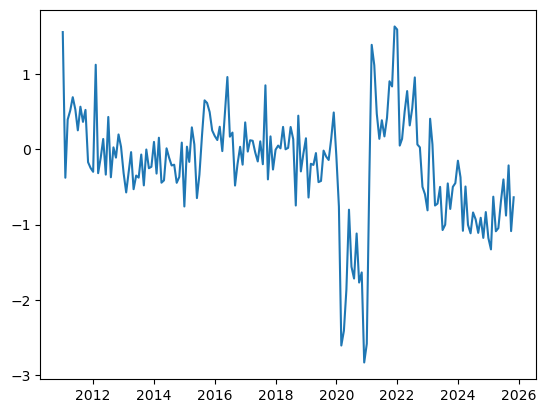

In [63]:
plt.plot(df_real['date'],df_real['real_index'])

# 디커플링 지수 계산

In [64]:
실물 = pd.read_csv('data/실물지표/실물지표계산.csv')
금융 = pd.read_csv('data/금융지표/금융지표계산.csv')

실물_score = 실물['real_index']
금융_score = 금융['fin_index']

df = pd.merge(
    실물[['date','real_index']],
    금융[['date','fin_index']],  # 실제 금융 컬럼명으로 수정
    on='date',
    how='inner'
)

df = df.sort_values('date')


In [65]:
df['decoupling'] = df['fin_index'] - df['real_index']
df['decoupling'].describe()

count    179.000000
mean       0.088562
std        0.796405
min       -1.717963
25%       -0.393688
50%       -0.101437
75%        0.437085
max        3.168849
Name: decoupling, dtype: float64

In [66]:
df.to_csv('data/decoupling.csv')

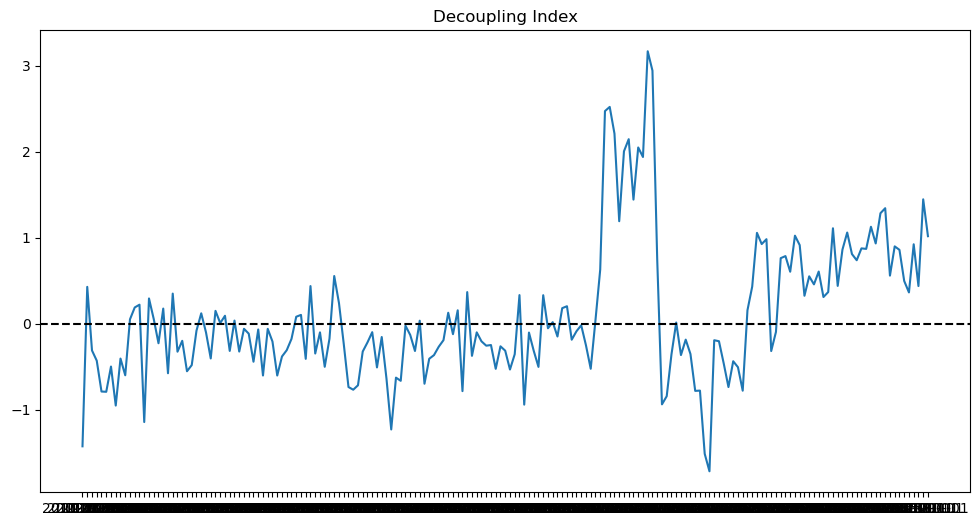

In [67]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['decoupling'])
plt.axhline(0, color='black', linestyle='--')
plt.title('Decoupling Index')
plt.savefig('wow.png')
plt.show()

In [68]:
df['date'] = pd.to_datetime(df['date'])


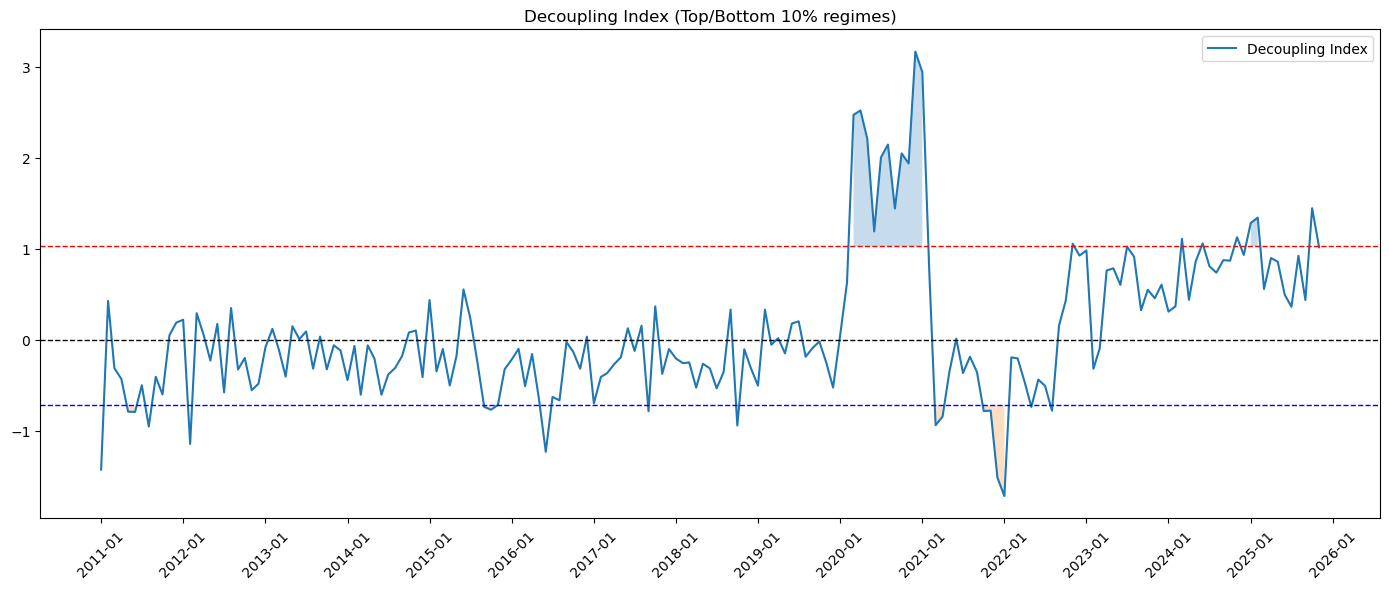

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = df.sort_values('date')

upper = df['decoupling'].quantile(0.90)
lower = df['decoupling'].quantile(0.10)

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['date'], df['decoupling'], label='Decoupling Index')

ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.axhline(upper, color='red', linestyle='--', linewidth=1)
ax.axhline(lower, color='blue', linestyle='--', linewidth=1)

ax.fill_between(df['date'], df['decoupling'], upper,
                where=(df['decoupling'] > upper),
                alpha=0.25)

ax.fill_between(df['date'], df['decoupling'], lower,
                where=(df['decoupling'] < lower),
                alpha=0.25)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.set_title('Decoupling Index (Top/Bottom 10% regimes)')
ax.legend()
plt.tight_layout()
plt.show()
